In [192]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
from __future__ import annotations
import numpy as np
import cmath

from mflex.simulate.simulate_boundary import dipole

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield, lf3d, j3d
from mhsflex.vis import plot, plot_plasma_parameters
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt

from mhsflex.poloidal import phi, phi_complex, dphidz_complex, dphidz

rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c1 = (0.439, 0.788, 1.000)
c2 = (0.420, 0.502, 1.000)
c3 = "black"
c4 = (1.000, 0.224, 0.376)
c5 = (0.784, 0.231, 0.576)
c7 = (0.992, 0.251, 0.733)
c8 = (0.867, 0.871, 0.184)
c9 = (0.949, 0.922, 0.678)
c10 = (0.984, 0.455, 0.231)
c11 = (0.765, 0.835, 0.922)
c12 = (0.965, 0.694, 0.486)
c13 = (0.992, 0.584, 0.820)

In [3]:
nresol_x = 200
nresol_y = 200
nresol_z = 400
xmin = 0.0
xmax = 20.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2.0

nf_max = 200

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [4]:
length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * data2d.px
length_scale_y = 2.0 * nresol_y * data2d.py

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(data2d.nf) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(data2d.nf) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(data2d.nf) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

In [5]:
print(k2_arr.max())

1954.2310194376987


In [6]:
print(k2_arr.min())

0.04934802200544679


In [6]:
np.sqrt(k2_arr.min())

0.2221441469079183

In [155]:
alpha = 0.2

In [161]:
a = 0.49996

k_crit = alpha**2 / (1 - 2 * a)

In [162]:
k_crit

500.00000000019395

In [163]:
count_complex = 0
count = 0

for ix in range(data2d.nf):
    for iy in range(data2d.nf):
        k2 = k2_arr[iy, ix]
        if k2 < k_crit:
            count_complex += 1
        if k2 > k_crit:
            count += 1

In [164]:
count_complex

16067

In [165]:
count

23933

In [166]:
phi_hyperbolic = np.zeros((nf_max, nf_max, nresol_z))
phi_trigonometric = np.zeros((nf_max, nf_max, nresol_z))
phi_hybrid = np.zeros((nf_max, nf_max, nresol_z))

dphi_hyperbolic = np.zeros((nf_max, nf_max, nresol_z))
dphi_trigonometric = np.zeros((nf_max, nf_max, nresol_z))
dphi_hybrid = np.zeros((nf_max, nf_max, nresol_z))

In [167]:
z0 = 2.0
deltaz = 0.2
b = 1.0

In [170]:
a = 0.05

for iz, z in enumerate(z_arr):
    p_arr = (
        0.5
        * deltaz
        * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a - a * b) - alpha**2)
    )
    q_arr = (
        0.5
        * deltaz
        * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a + a * b) - alpha**2)
    )

    phi_hyperbolic[:, :, iz] = phi(z, p_arr, q_arr, z0, deltaz)
    dphi_hyperbolic[:, :, iz] = dphidz(z, p_arr, q_arr, z0, deltaz)

In [171]:
a = 0.6

for iz, z in enumerate(z_arr):
    v_arr = (
        0.5
        * deltaz
        * np.emath.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a - a * b) - alpha**2).imag
    )
    q_arr = (
        0.5
        * deltaz
        * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a + a * b) - alpha**2)
    )

    phi_trigonometric[:, :, iz] = phi_complex(z, v_arr, q_arr, z0, deltaz)
    dphi_trigonometric[:, :, iz] = dphidz_complex(z, v_arr, q_arr, z0, deltaz)

In [173]:
a = 0.49996

k_crit = alpha**2 / (1 - 2 * a)


for ix in range(nf_max):
    for iy in range(nf_max):

        if k2_arr[iy, ix] < k_crit:
            for iz, z in enumerate(z_arr):
                v_arr = (
                    0.5
                    * deltaz
                    * np.emath.sqrt(k2_arr[iy, ix] * (1.0 - a - a * b) - alpha**2).imag
                )
                q_arr = (
                    0.5
                    * deltaz
                    * np.sqrt(k2_arr[iy, ix] * (1.0 - a + a * b) - alpha**2)
                )
                phi_hybrid[iy, ix, iz] = phi_complex(z, v_arr, q_arr, z0, deltaz)
                dphi_hybrid[iy, ix, iz] = dphidz_complex(z, v_arr, q_arr, z0, deltaz)
        else:
            for iz, z in enumerate(z_arr):
                
                p_arr = (
                    0.5
                    * deltaz
                    * np.sqrt(k2_arr[iy, ix] * (1.0 - a - a * b) - alpha**2)
                )
                q_arr = (
                    0.5
                    * deltaz
                    * np.sqrt(k2_arr[iy, ix] * (1.0 - a + a * b) - alpha**2)
                )
                phi_hybrid[iy, ix, iz] = phi(z, p_arr, q_arr, z0, deltaz)
                dphi_hybrid[iy, ix, iz] = dphidz(z, p_arr, q_arr, z0, deltaz)

In [132]:
folder = "/Users/lilli/Desktop/Thesis/phi-complex"

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_32116/4233258159.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


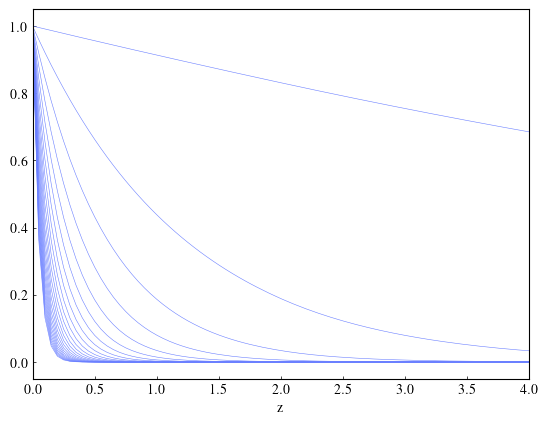

In [191]:
for ix in range(0, 100, 4):
    #for iy in range(0, 100, 4):
    plt.plot(
        z_arr,
        phi_hyperbolic[ix, ix, :],
        linewidth=0.4,
        color=c2,
        # label="N+W (2019)"
    )
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
plotname = folder + "/phi_hyperbolic.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_32116/1563523385.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


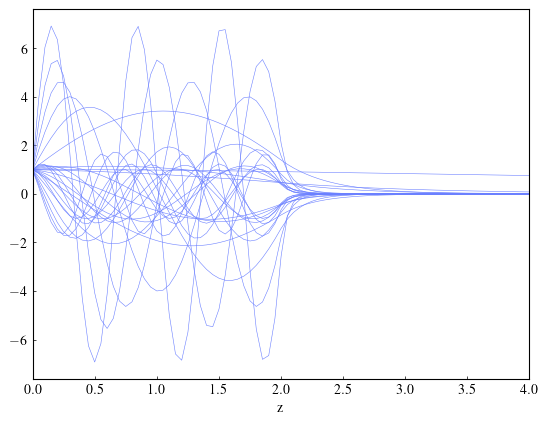

In [190]:
#for ix in range(0, 200, 1):
for iy in range(0, 100, 4):
    plt.plot(
        z_arr,
        phi_trigonometric[iy, iy, :],
        linewidth=0.4,
        color=c2,
        # label="N+W (2019)"
    )
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
plotname = folder + "/phi_trig.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_32116/394487136.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


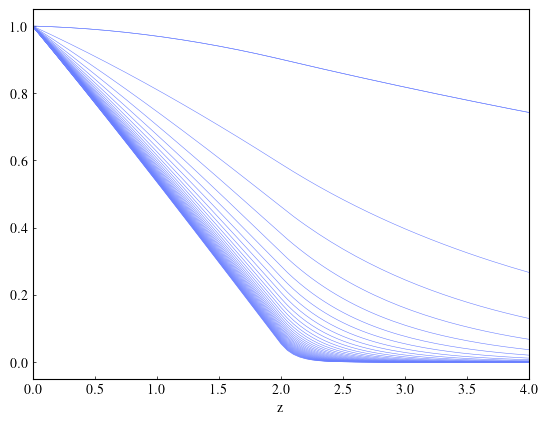

In [189]:
#for ix in range(0, 200, 1):
for iy in range(0, 40, 1):
    plt.plot(
        z_arr,
        phi_hybrid[iy, iy, :],
        linewidth=0.4,
        color=c2,
        # alpha=0.5
        # label="N+W (2019)"
    )
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
plotname = folder + "/phi_hybrid.png"
plt.tick_params(direction="in", length=2, width=0.5)
# plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_32116/574834328.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


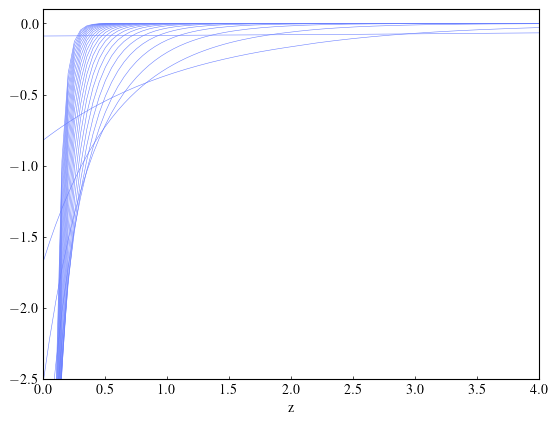

In [186]:
# for ix in range(0, nresol_y, 8):
#     for iy in range(0, nresol_y, 8):
for iy in range(0, 100, 4):
    plt.plot(
        z_arr,
        dphi_hyperbolic[iy, iy, :],
        linewidth=0.4,
        color=c2,
        # label="N+W (2019)"
    )
plt.xlim([0, 2 * z0])
plt.ylim([-2.5, 0.1])
plt.legend(frameon=False)
plt.xlabel("z")
plotname = folder + "/dphi_hyperbolic.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_32116/3959163869.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


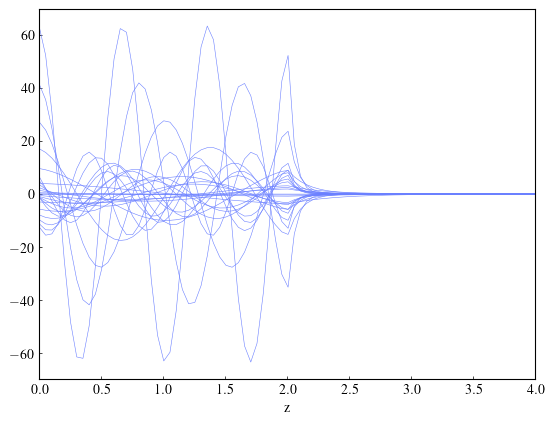

In [185]:
# for ix in range(0, nresol_y, 8):
#     for iy in range(0, nresol_y, 8):
for iy in range(0, 100, 4):
    plt.plot(
        z_arr,
        dphi_trigonometric[iy, iy, :],
        linewidth=0.4,
        color=c2,
        # label="N+W (2019)"
    )
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
plotname = folder + "/dphi_trig.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_32116/2072930224.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


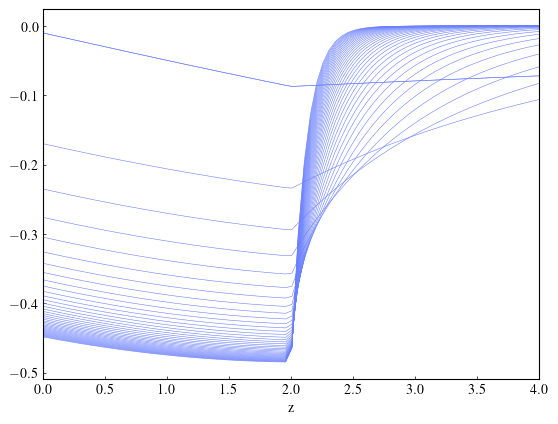

In [188]:
# for ix in range(0, nresol_y, 8):
#     for iy in range(0, nresol_y, 8):
for iy in range(0, 40, 1):
    plt.plot(
        z_arr,
        dphi_hybrid[iy, iy, :],
        linewidth=0.4,
        color=c2,
        # label="N+W (2019)"
    )
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
plotname = folder + "/dphi_hybrid.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()